In [24]:
import sys,os
__script_path=os.path.abspath(globals().get('__file__','.'))
__script_dir = os.path.dirname(__script_path)
root_dir = os.path.abspath(f'{__script_dir}/../../..')
print(root_dir)
for lib in [root_dir][::-1]:
    if lib in sys.path:
        sys.path.remove(lib)
    sys.path.insert(0,lib)
from libs.common import *
from config.config import *

c:\Users\PC\Data\ads_fraud_detection


In [25]:
save_dir=f"{exps_dir}/exp2/exp_gan"

save_dir = f"{save_dir}"
os.makedirs(save_dir, exist_ok=True)
test_size=0.33
seed=42

In [26]:
x_train=pd.read_excel(f'{save_dir}/x_train.xlsx')
y_train=pd.read_excel(f'{save_dir}/y_train.xlsx')
x_test=pd.read_excel(f'{save_dir}/x_test.xlsx')
y_test=pd.read_excel(f'{save_dir}/y_test.xlsx')
class_weights_dict=dict(np.load(f'{save_dir}/class_weights_dict.npz',allow_pickle=True))['class_weights_dict']
class_weights_dict = {key: value for key, value in class_weights_dict.item().items()}
class_weights_dict

{0: 1.0352032938754503, 1: 0.9671122223290701}

In [27]:
feature_selection=dict(np.load(f'{save_dir}/feature_model_selection.npz',allow_pickle=True))['feature_model_selection']
feature_selection = {key: value for key, value in feature_selection.item().items()}
feature_selection

{'LR': ['AccidentArea',
  'AddressChange_Claim',
  'AgentType',
  'Days_Policy_Claim',
  'Fault',
  'NumberOfCars',
  'NumberOfSuppliments',
  'Sex',
  'WitnessPresent',
  'Year'],
 'LDA': ['AccidentArea',
  'AddressChange_Claim',
  'AgentType',
  'BasePolicy',
  'Days_Policy_Claim',
  'Fault',
  'NumberOfCars',
  'NumberOfSuppliments',
  'WitnessPresent',
  'Year'],
 'DTC': ['Age',
  'Make',
  'Month',
  'MonthClaimed',
  'PolicyNumber',
  'RepNumber',
  'WeekOfMonth',
  'WeekOfMonthClaimed',
  'week_claimed',
  'week_incident'],
 'RD': ['Age',
  'AgeOfPolicyHolder',
  'DayOfWeekClaimed',
  'Make',
  'Month',
  'MonthClaimed',
  'PolicyNumber',
  'RepNumber',
  'week_claimed',
  'week_incident'],
 'LGBM': ['Age',
  'AgeOfVehicle',
  'Make',
  'Month',
  'MonthClaimed',
  'PolicyNumber',
  'PolicyType',
  'RepNumber',
  'week_claimed',
  'week_incident'],
 'XGB': ['AccidentArea',
  'AddressChange_Claim',
  'AgentType',
  'BasePolicy',
  'Days_Policy_Claim',
  'Fault',
  'NumberOfCars',

In [28]:
xgb_model=joblib.load(f'{save_dir}/xgb_model.joblib')
rf_model=joblib.load(f'{save_dir}/rf_model.joblib')
lgbm_model=joblib.load(f'{save_dir}/lgbm_model.joblib')

#### Voting ensemble

[LightGBM] [Info] Number of positive: 10399, number of negative: 9715
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000819 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1193
[LightGBM] [Info] Number of data points in the train set: 20114, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.517003 -> initscore=0.068039
[LightGBM] [Info] Start training from score 0.068039
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

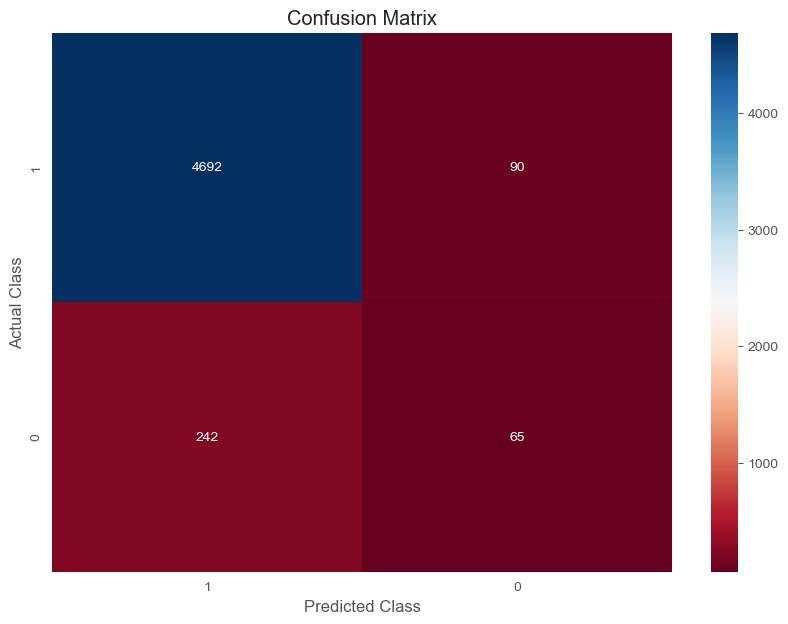

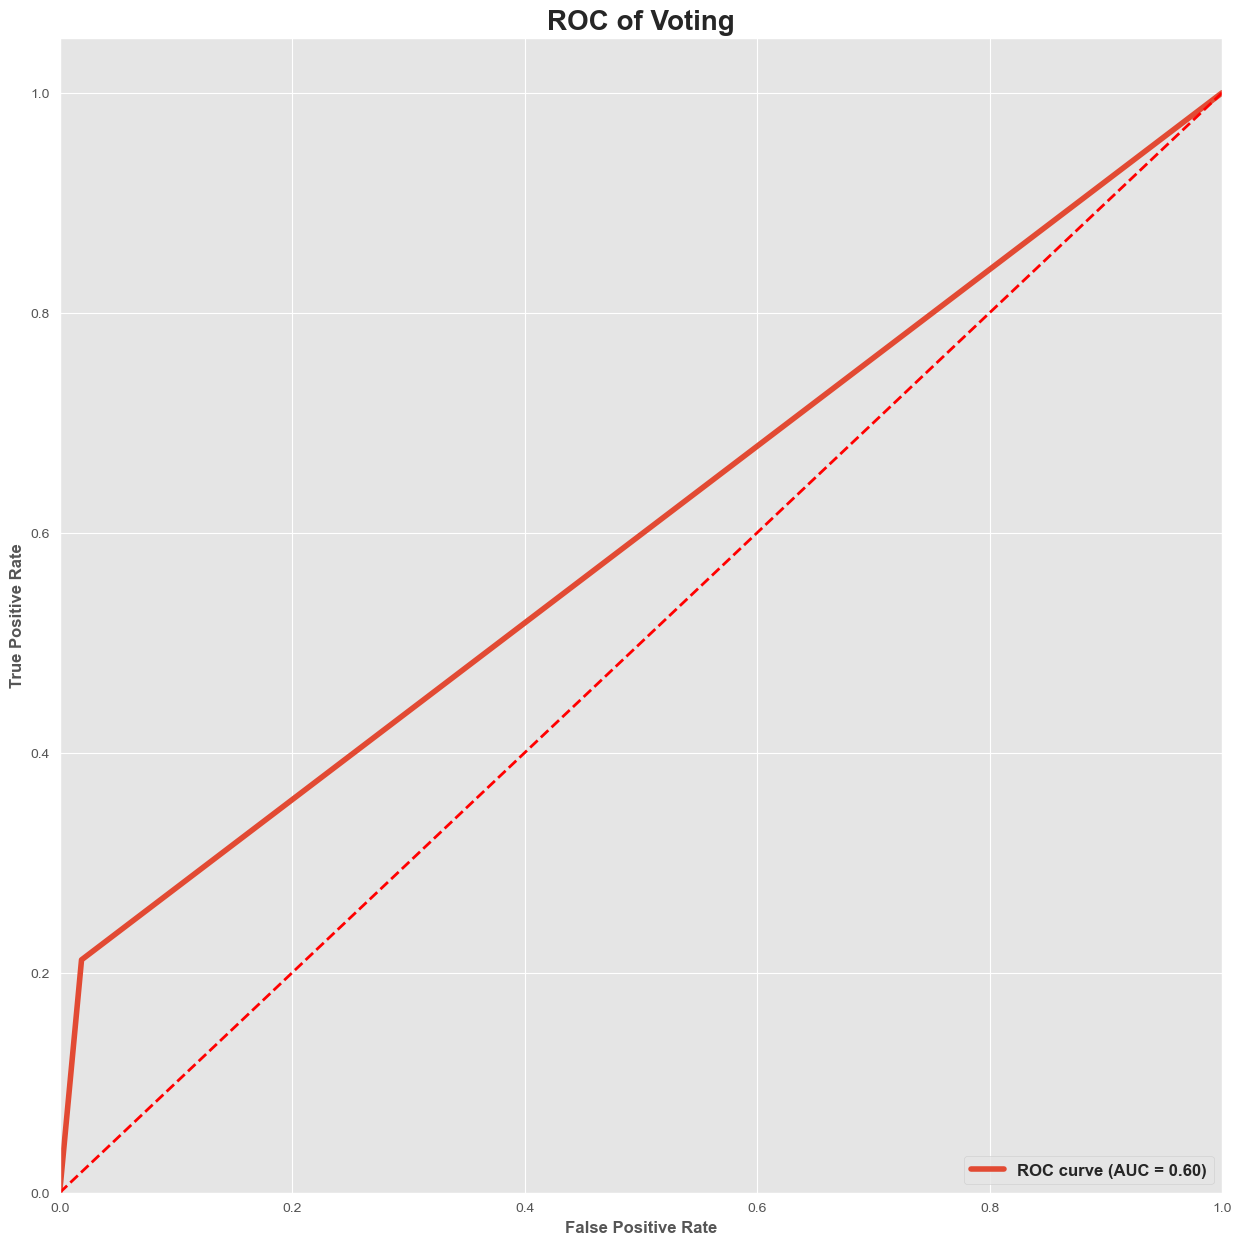

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.98      0.97      4782
           1       0.42      0.21      0.28       307

    accuracy                           0.93      5089
   macro avg       0.69      0.60      0.62      5089
weighted avg       0.92      0.93      0.92      5089



In [29]:
from sklearn.ensemble import VotingClassifier
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score
# from sklearn.linear_model import LogisticRegression
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.LGBM import SVC

# Load your dataset và chia thành tập huấn luyện và tập kiểm tra
# X_train, X_test, y_train, y_test = ...

# # Khởi tạo các mô hình
# model1 = LogisticRegression()
# model2 = DecisionTreeClassifier()
# model3 = SVC()

# Tạo một ensemble voting classifier
voting_clf = VotingClassifier(estimators=[('lr', rf_model), ('bg', xgb_model), ('svc', lgbm_model)], voting='hard')

# Huấn luyện ensemble model
voting_clf.fit(x_train, y_train)

# Dự đoán trên tập kiểm tra
y_pred = voting_clf.predict(x_test)

# Đánh giá độ chính xác của ensemble model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


# Tạo ma trận nhầm lẫn
conf_matrix = confusion_matrix(y_test, y_pred)


# In ma trận nhầm lẫn dưới dạng heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", xticklabels=['1', '0'], yticklabels=['1', '0'], cmap='RdBu')
plt.title("Confusion Matrix")
plt.ylabel("Actual Class")
plt.xlabel("Predicted Class")
fig, ax = plt.subplots(1, 1, figsize=(15, 15))

fpr, tpr, _ = roc_curve(y_test, y_pred)

# Tính diện tích dưới đường cong ROC (AUC)
roc_auc = auc(fpr, tpr)

# Vẽ đường cong ROC
ax.plot(fpr, tpr, lw=4, label='ROC curve (AUC = %0.2f)' % roc_auc)
ax.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=12, weight='bold')  # Đặt kích thước và độ dày cho nhãn trục x
ax.set_ylabel('True Positive Rate', fontsize=12, weight='bold')   # Đặt kích thước và độ dày cho nhãn trục y
ax.set_title(f'ROC of Voting',fontsize=20, weight='bold')  # Đặt kích thước và độ dày cho tiêu đề
ax.legend(loc="lower right", prop={'size': 12, 'weight': 'bold'})
plt.show()

# Đánh giá ma trận nhầm lẫn
print("Classification Report:")
print(classification_report(y_test, y_pred))



#### Gradient Boosting ensemble

In [30]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1.0],
    'max_depth': [1, 3, 5],
    'subsample': [0.8, 1.0],
    'min_samples_split': [2, 5, 10]
}


grid_search_gb  = GridSearchCV(estimator=GradientBoostingClassifier(random_state=42),
                              param_grid=param_grid,
                              scoring='f1',
                              cv=5, n_jobs=-1, verbose=2)
grid_search_gb.fit(x_train[feature_selection['BG']], y_train)
xgb_model_tuning = grid_search_gb.best_estimator_


print("Best Decision Tree Hyperparameters:")
print(grid_search_gb.best_params_)


Fitting 5 folds for each of 162 candidates, totalling 810 fits
Best Decision Tree Hyperparameters:
{'learning_rate': 0.1, 'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 200, 'subsample': 0.8}


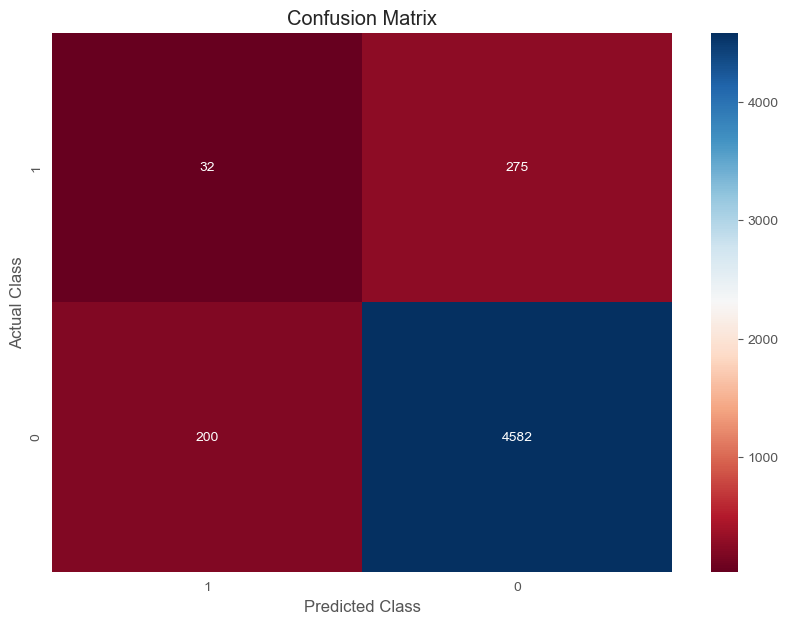

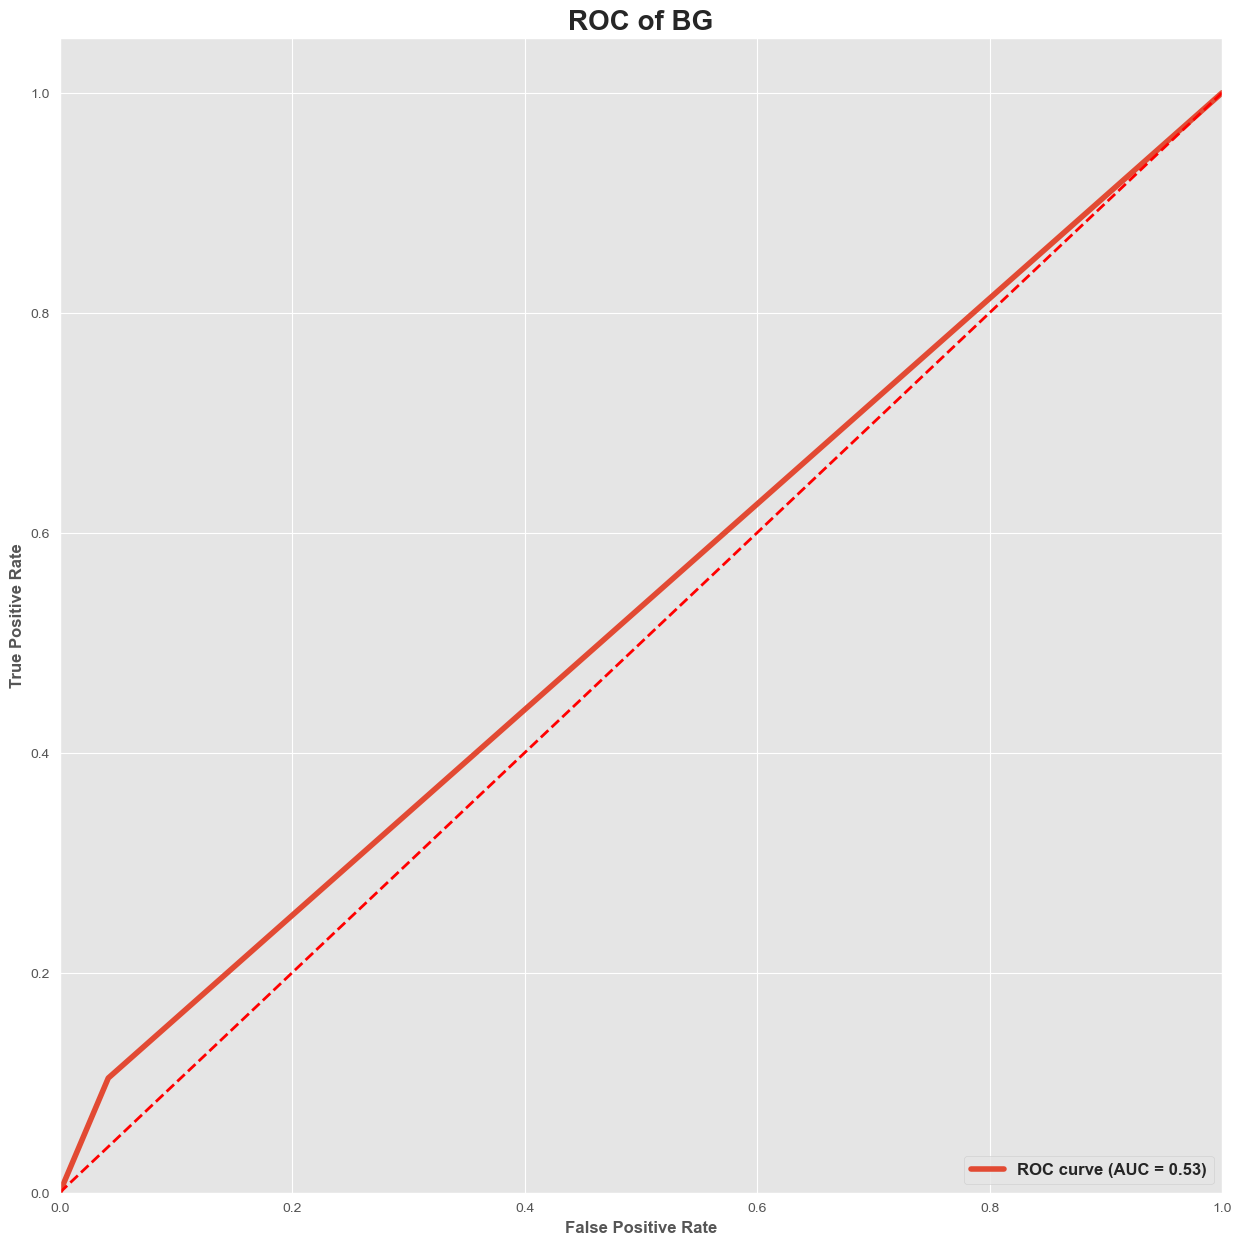

              precision    recall  f1-score   support

           0       0.94      0.96      0.95      4782
           1       0.14      0.10      0.12       307

    accuracy                           0.91      5089
   macro avg       0.54      0.53      0.53      5089
weighted avg       0.89      0.91      0.90      5089



In [31]:
predictions = xgb_model_tuning.predict(x_test[feature_selection['BG']])

conf_matrix = confusion_matrix(y_test, predictions,labels=[1,0])

# Vẽ heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", xticklabels=['1', '0'], yticklabels=['1', '0'],cmap='RdBu')
plt.title("Confusion Matrix")
plt.ylabel("Actual Class")
plt.xlabel("Predicted Class")
fpr, tpr, _ = roc_curve(y_test, predictions)

# Tính diện tích dưới đường cong ROC (AUC)
roc_auc = auc(fpr, tpr)

# Vẽ đường cong ROC
fig, ax = plt.subplots(1, 1, figsize=(15, 15))

ax.plot(fpr, tpr, lw=4, label='ROC curve (AUC = %0.2f)' % roc_auc)
ax.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=12, weight='bold')  # Đặt kích thước và độ dày cho nhãn trục x
ax.set_ylabel('True Positive Rate', fontsize=12, weight='bold')   # Đặt kích thước và độ dày cho nhãn trục y
ax.set_title(f'ROC of BG',fontsize=20, weight='bold')  # Đặt kích thước và độ dày cho tiêu đề
ax.legend(loc="lower right", prop={'size': 12, 'weight': 'bold'})
plt.show()
# evaluate_result['LGBM']=classification_report(y_test, predictions)

print(classification_report(y_test, predictions))


#### AdaBoostClassifier ensemble

AdaBoost Accuracy XGB: 0.06032619375122814


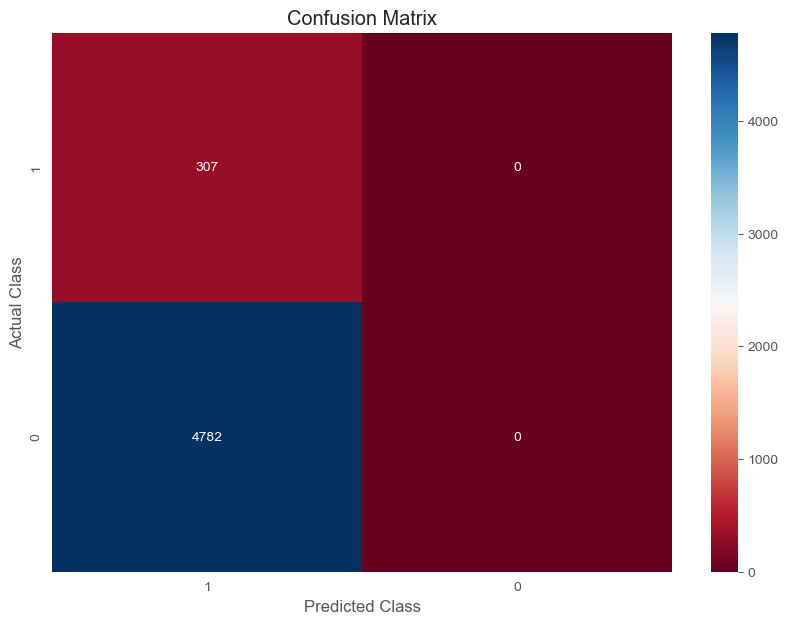

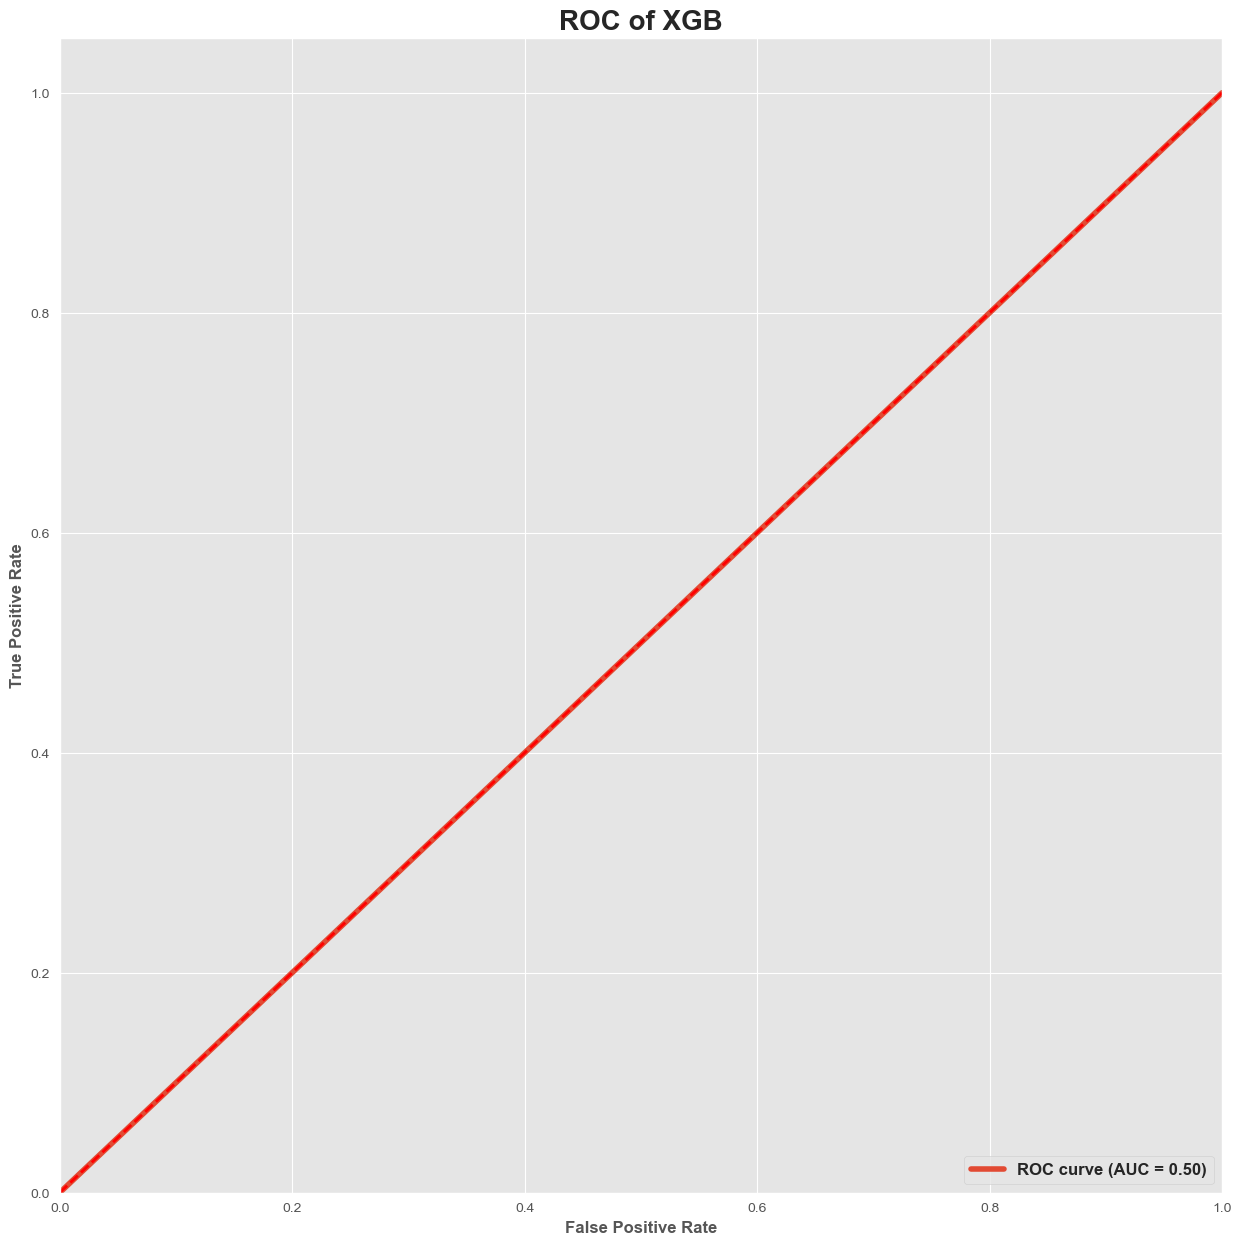

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      4782
           1       0.06      1.00      0.11       307

    accuracy                           0.06      5089
   macro avg       0.03      0.50      0.06      5089
weighted avg       0.00      0.06      0.01      5089

AdaBoost Accuracy RD: 0.9322067203772844


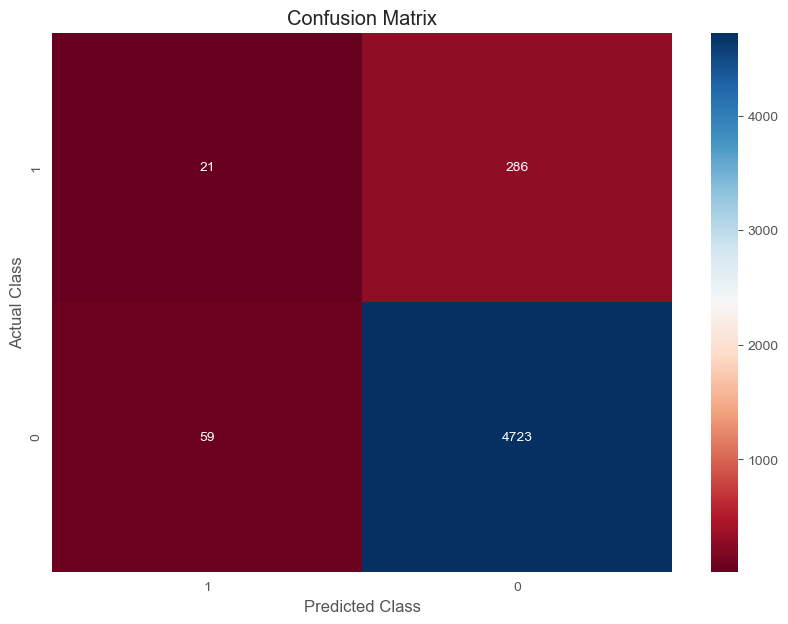

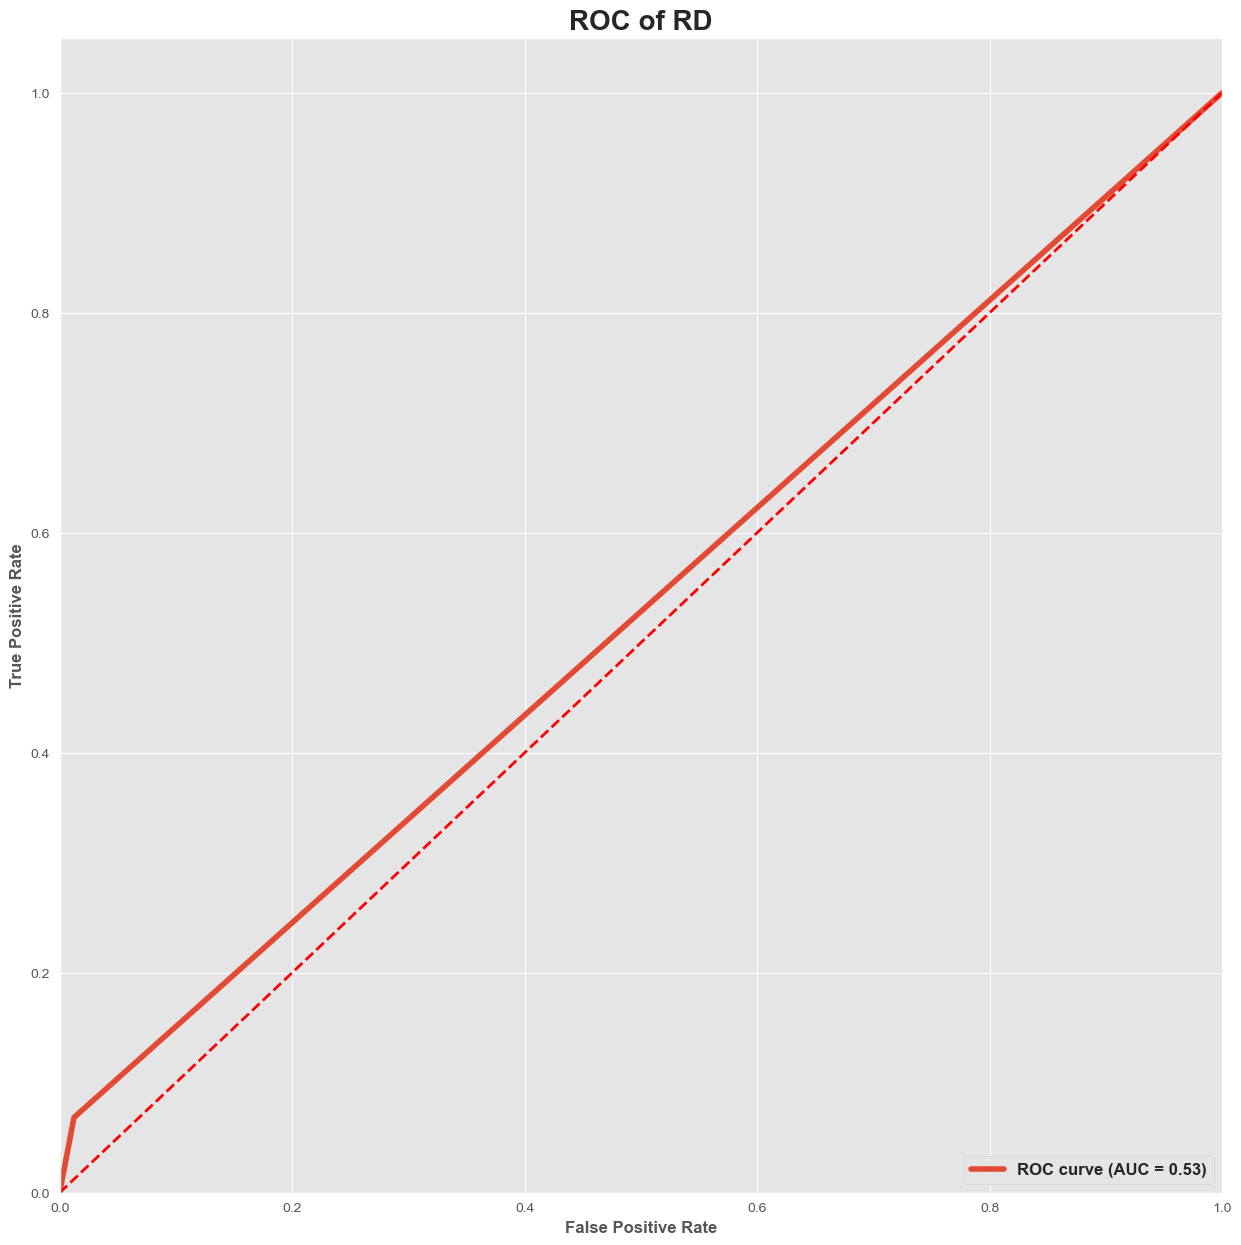

              precision    recall  f1-score   support

           0       0.94      0.99      0.96      4782
           1       0.26      0.07      0.11       307

    accuracy                           0.93      5089
   macro avg       0.60      0.53      0.54      5089
weighted avg       0.90      0.93      0.91      5089



In [32]:
from sklearn.ensemble import AdaBoostClassifier
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score
# from sklearn.tree import DecisionTreeClassifier

# Load your dataset và chia thành tập huấn luyện và tập kiểm tra
# X_train, X_test, y_train, y_test = ...

# Khởi tạo mô hình cơ sở
models =[('XGB',xgb_model),('RD',rf_model)]
# Tạo mô hình AdaBoost
for name,model in models:
    if name=='SVM':
        adaboost_model = AdaBoostClassifier(base_estimator=model, n_estimators=50, random_state=42, algorithm='SAMME')
    else:
        adaboost_model = AdaBoostClassifier(base_estimator=model, n_estimators=50, random_state=42)

    # Huấn luyện mô hình AdaBoost
    adaboost_model.fit(x_train, y_train)

    # Dự đoán trên tập kiểm tra
    y_pred = adaboost_model.predict(x_test)

    # Đánh giá độ chính xác của mô hình
    accuracy = accuracy_score(y_test, y_pred)
    print(f"AdaBoost Accuracy {name}:", accuracy)
    predictions = adaboost_model.predict(x_test)

    conf_matrix = confusion_matrix(y_test, predictions,labels=[1,0])

    # Vẽ heatmap
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt="d", xticklabels=['1', '0'], yticklabels=['1', '0'],cmap='RdBu')
    plt.title("Confusion Matrix")
    plt.ylabel("Actual Class")
    plt.xlabel("Predicted Class")
    fig, ax = plt.subplots(1, 1, figsize=(15, 15))

    fpr, tpr, _ = roc_curve(y_test, y_pred)

    # Tính diện tích dưới đường cong ROC (AUC)
    roc_auc = auc(fpr, tpr)

    # Vẽ đường cong ROC
    ax.plot(fpr, tpr, lw=4, label='ROC curve (AUC = %0.2f)' % roc_auc)
    ax.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate', fontsize=12, weight='bold')  # Đặt kích thước và độ dày cho nhãn trục x
    ax.set_ylabel('True Positive Rate', fontsize=12, weight='bold')   # Đặt kích thước và độ dày cho nhãn trục y
    ax.set_title(f'ROC of {name}',fontsize=20, weight='bold')  # Đặt kích thước và độ dày cho tiêu đề
    ax.legend(loc="lower right", prop={'size': 12, 'weight': 'bold'})
    plt.show()

    print(classification_report(y_test, predictions))


#### Bagging ensemble

[LightGBM] [Info] Number of positive: 10399, number of negative: 9715
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002471 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1193
[LightGBM] [Info] Number of data points in the train set: 20114, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.513274 -> initscore=0.053110
[LightGBM] [Info] Start training from score 0.053110
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

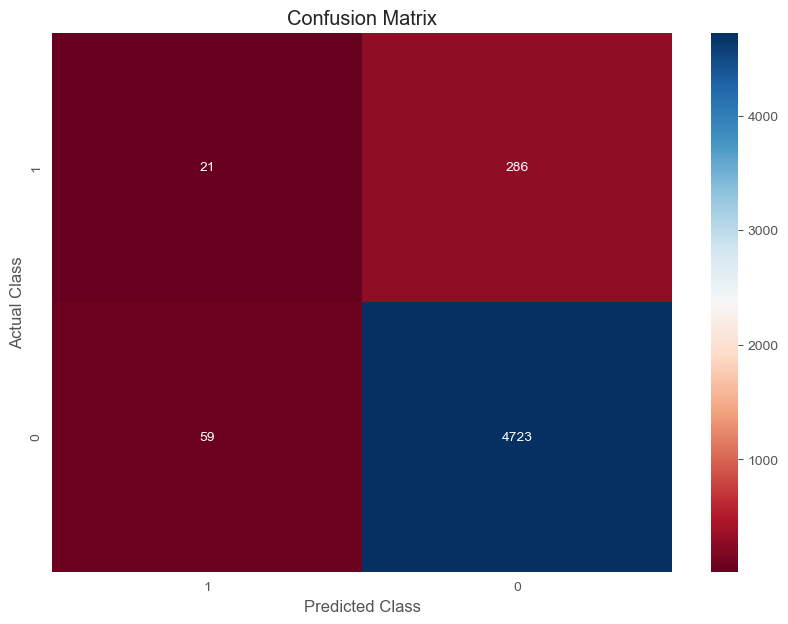

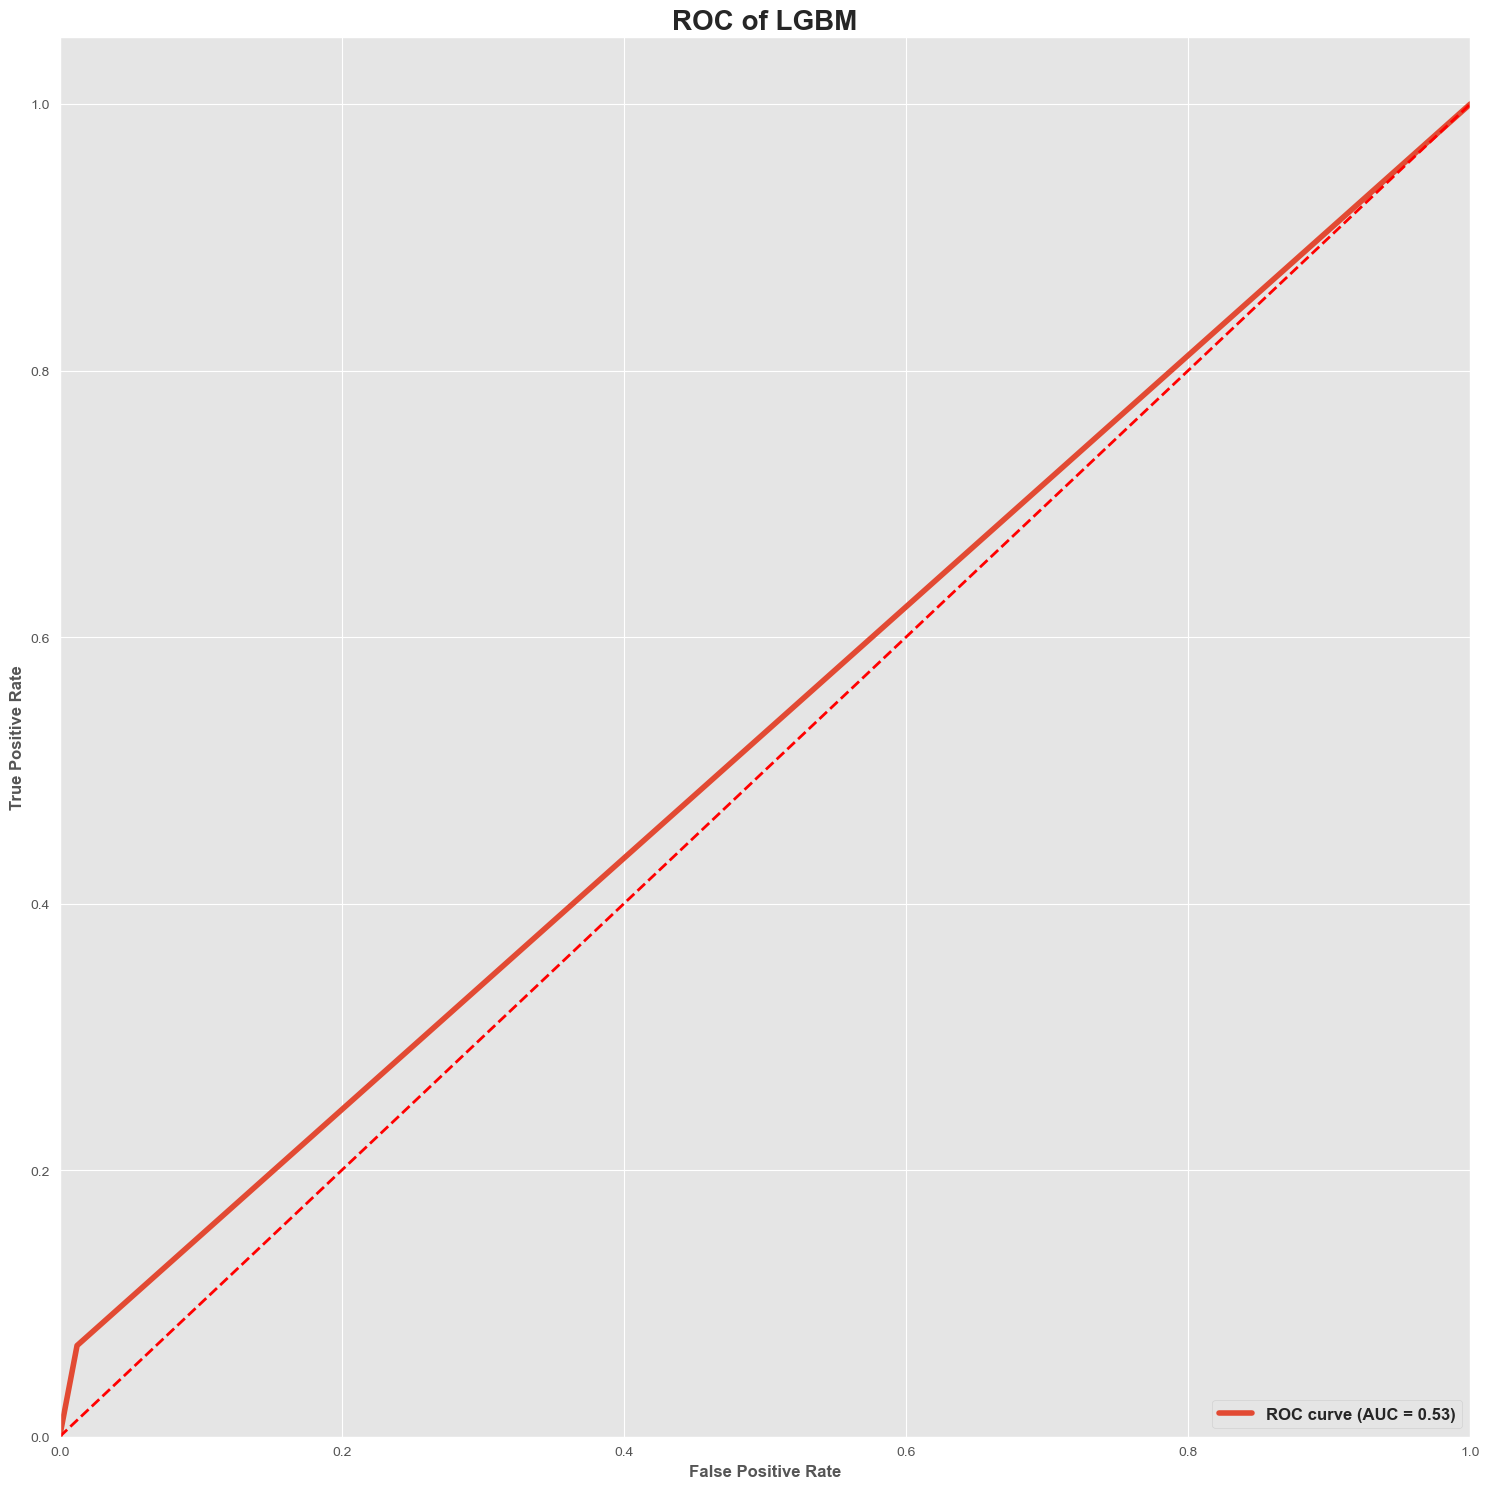

              precision    recall  f1-score   support

           0       0.94      0.99      0.96      4782
           1       0.26      0.07      0.11       307

    accuracy                           0.93      5089
   macro avg       0.60      0.53      0.54      5089
weighted avg       0.90      0.93      0.91      5089

Bagging Accuracy XGB: 0.9322067203772844


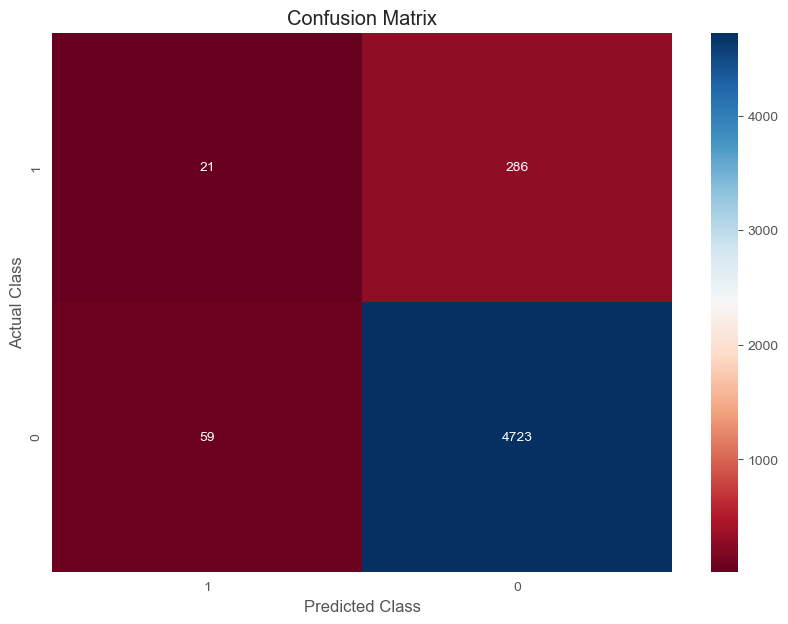

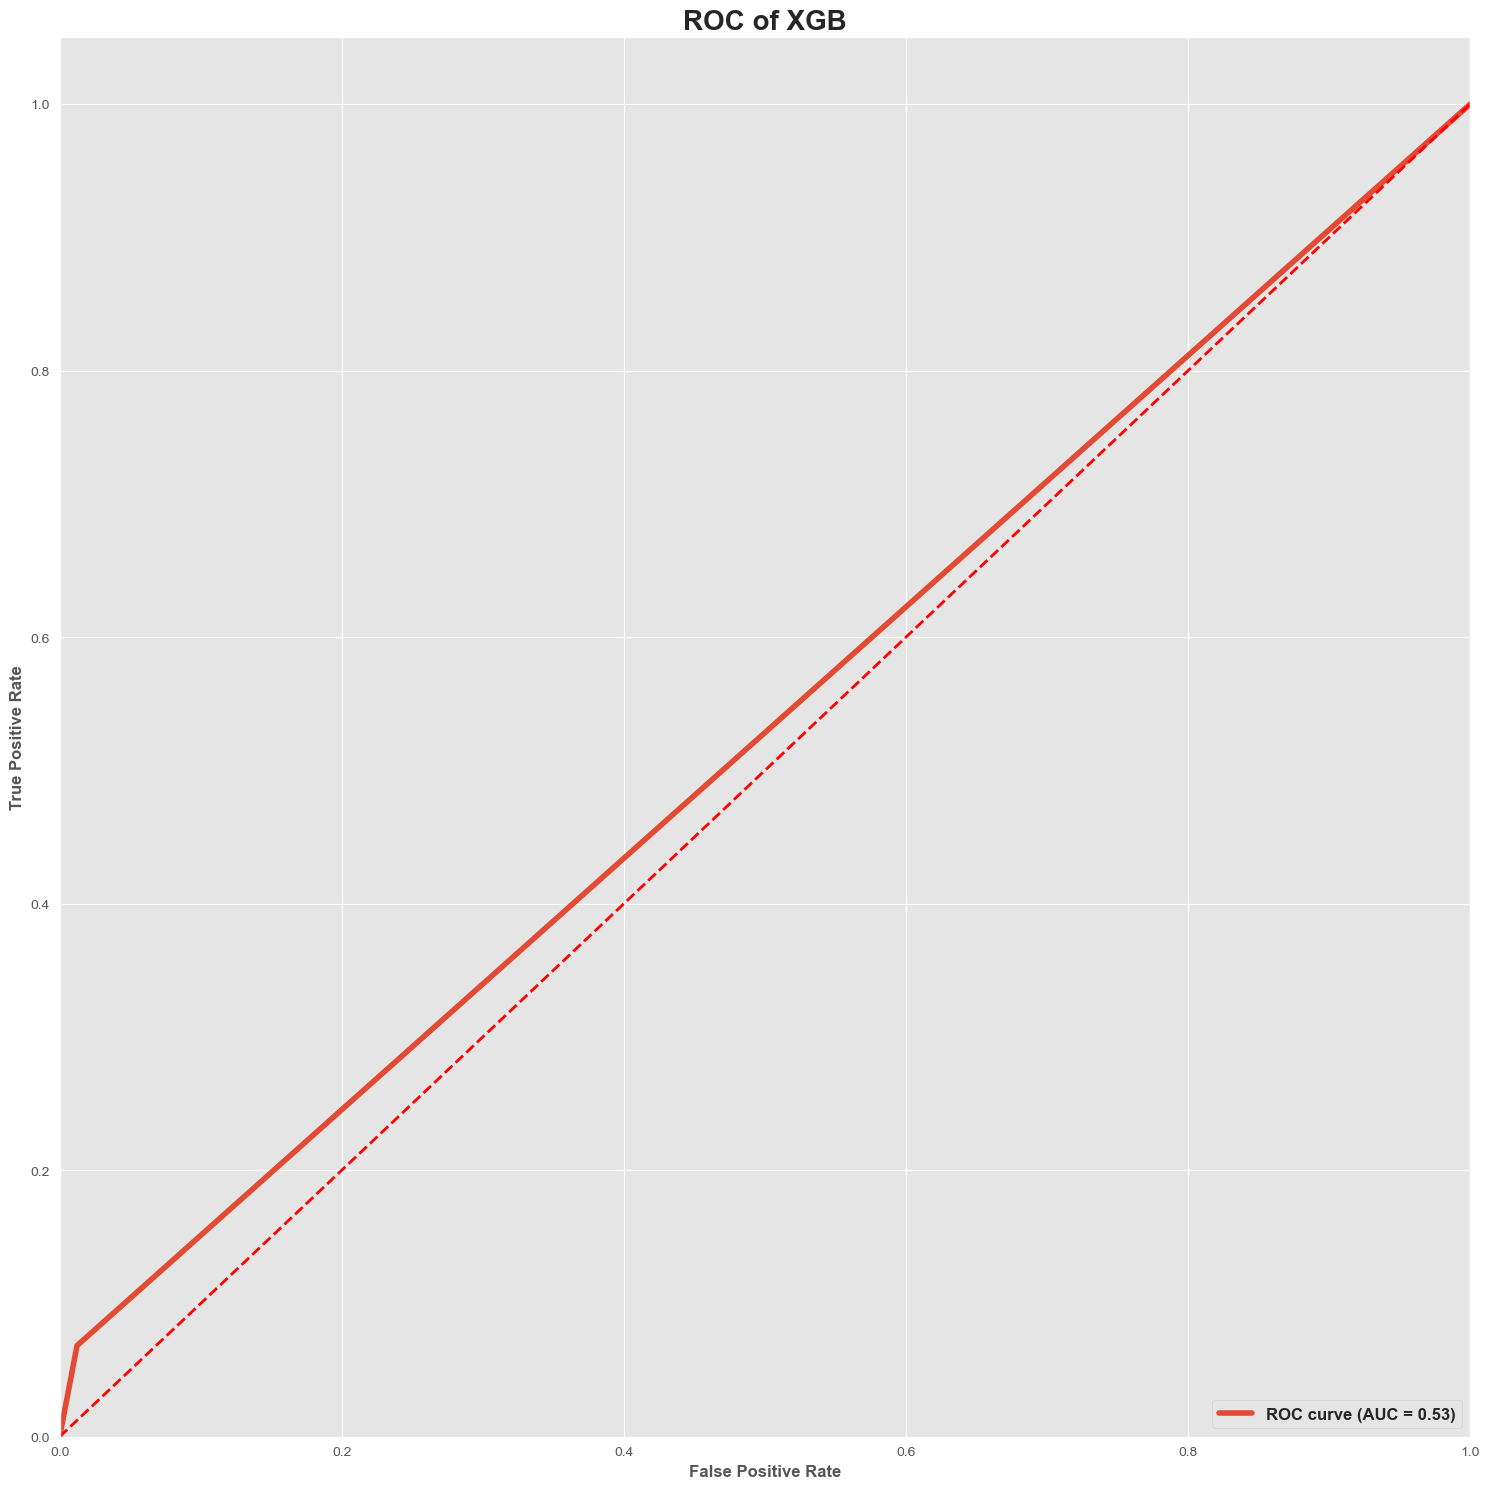

              precision    recall  f1-score   support

           0       0.94      0.99      0.96      4782
           1       0.26      0.07      0.11       307

    accuracy                           0.93      5089
   macro avg       0.60      0.53      0.54      5089
weighted avg       0.90      0.93      0.91      5089

Bagging Accuracy RD: 0.9322067203772844


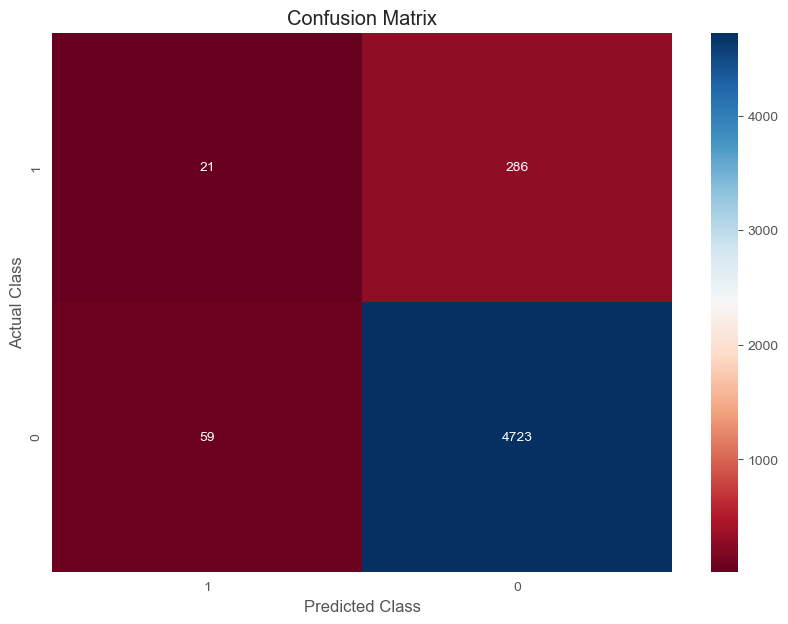

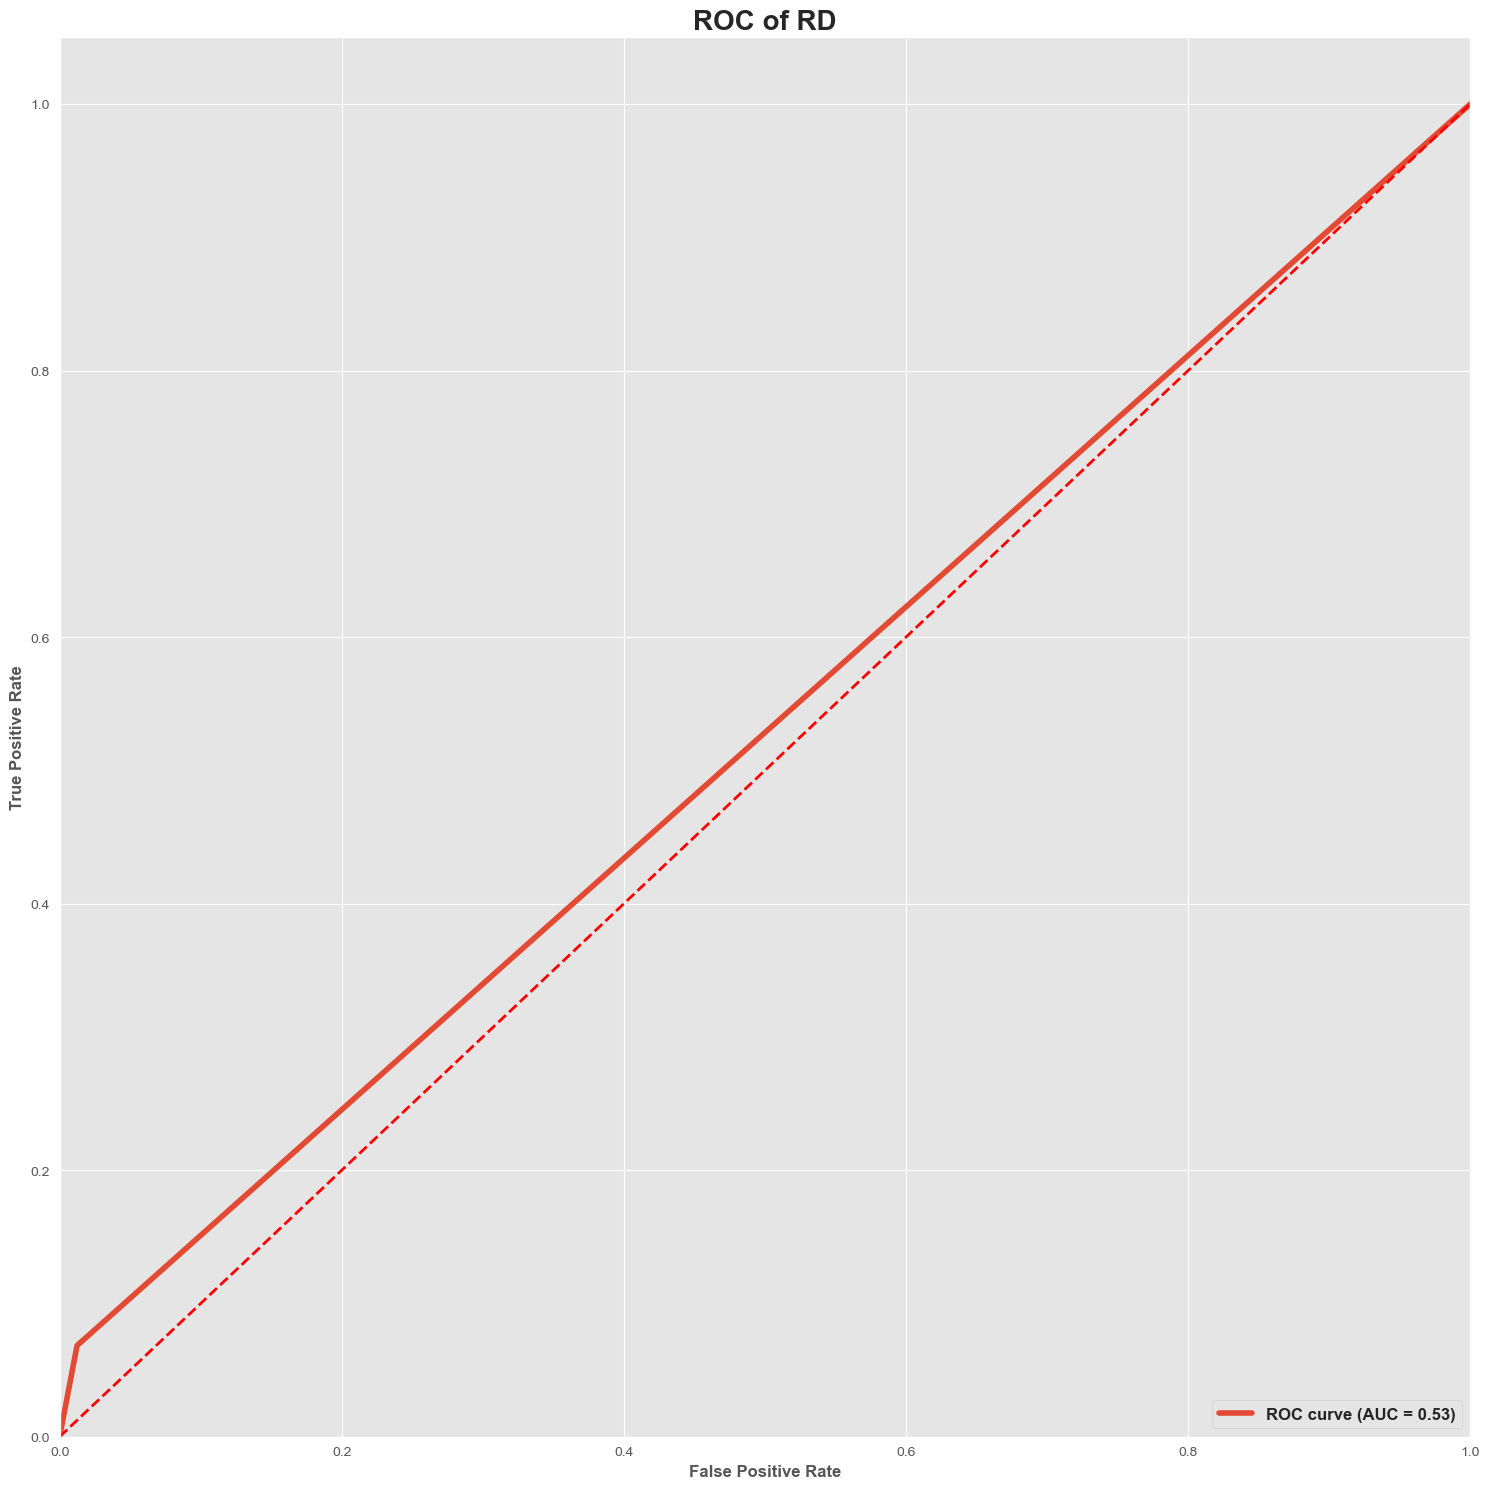

              precision    recall  f1-score   support

           0       0.94      0.99      0.96      4782
           1       0.26      0.07      0.11       307

    accuracy                           0.93      5089
   macro avg       0.60      0.53      0.54      5089
weighted avg       0.90      0.93      0.91      5089



In [33]:
from sklearn.ensemble import BaggingClassifier
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score
# from sklearn.linear_model import LogisticRegression
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.svm import SVC

# Load your dataset và chia thành tập huấn luyện và tập kiểm tra
# X_train, X_test, y_train, y_test = ...

models =[('LGBM',lgbm_model),('XGB',xgb_model),('RD',rf_model)]
# Tạo mô hình AdaBoost
for name,model in models:
    bagging_model = BaggingClassifier(model, n_estimators=10, random_state=42)

# Huấn luyện mô hình Bagging
    bagging_model.fit(x_train, y_train)

    # Dự đoán trên tập kiểm tra
    y_pred = adaboost_model.predict(x_test)

    # Đánh giá độ chính xác của mô hình
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Bagging Accuracy {name}:", accuracy)
    predictions = adaboost_model.predict(x_test)

    conf_matrix = confusion_matrix(y_test, predictions,labels=[1,0])

    # Vẽ heatmap
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt="d", xticklabels=['1', '0'], yticklabels=['1', '0'],cmap='RdBu')
    plt.title("Confusion Matrix")
    plt.ylabel("Actual Class")
    plt.xlabel("Predicted Class")
    fpr, tpr, _ = roc_curve(y_test, predictions)

    # Tính diện tích dưới đường cong ROC (AUC)
    fig, ax = plt.subplots(1, 1, figsize=(15, 15))
    roc_auc = auc(fpr, tpr)

    # Vẽ đường cong ROC
    ax.plot(fpr, tpr, lw=4, label='ROC curve (AUC = %0.2f)' % roc_auc)
    ax.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate', fontsize=12, weight='bold')  # Đặt kích thước và độ dày cho nhãn trục x
    ax.set_ylabel('True Positive Rate', fontsize=12, weight='bold')   # Đặt kích thước và độ dày cho nhãn trục y
    ax.set_title(f'ROC of {name}',fontsize=20, weight='bold')  # Đặt kích thước và độ dày cho tiêu đề
    ax.legend(loc="lower right", prop={'size': 12, 'weight': 'bold'})  # Đặt kích thước và độ dày cho chú thích
    plt.tight_layout()

    plt.show()
    # evaluate_result['SVM']=classification_report(y_test, predictions)

    print(classification_report(y_test, predictions))



In [34]:
import numpy as np

# Assume we have predictions from three base models: model1_pred, model2_pred, model3_pred
model1_pred = lgbm_model.predict(x_test[feature_selection['LGBM']]) # Example predictions from model 1
model2_pred = xgb_model.predict(x_test[feature_selection['XGB']]) # Example predictions from model 2
model3_pred = rf_model.predict(x_test[feature_selection['RD']])  # Example predictions from model 3

# Define weights for each model
weights = [0.4, 0.6, 0.2]

# Compute weighted average predictions
weighted_avg_pred = np.average([model1_pred, model2_pred, model3_pred], axis=0, weights=weights)
binary_pred = np.where(weighted_avg_pred >= 0.5, 1, 0)

# print("Weighted Average Predictions:", weighted_avg_pred)
accuracy = accuracy_score(y_test, binary_pred)
print("Accuracy:", accuracy)


Accuracy: 0.8148948712910199


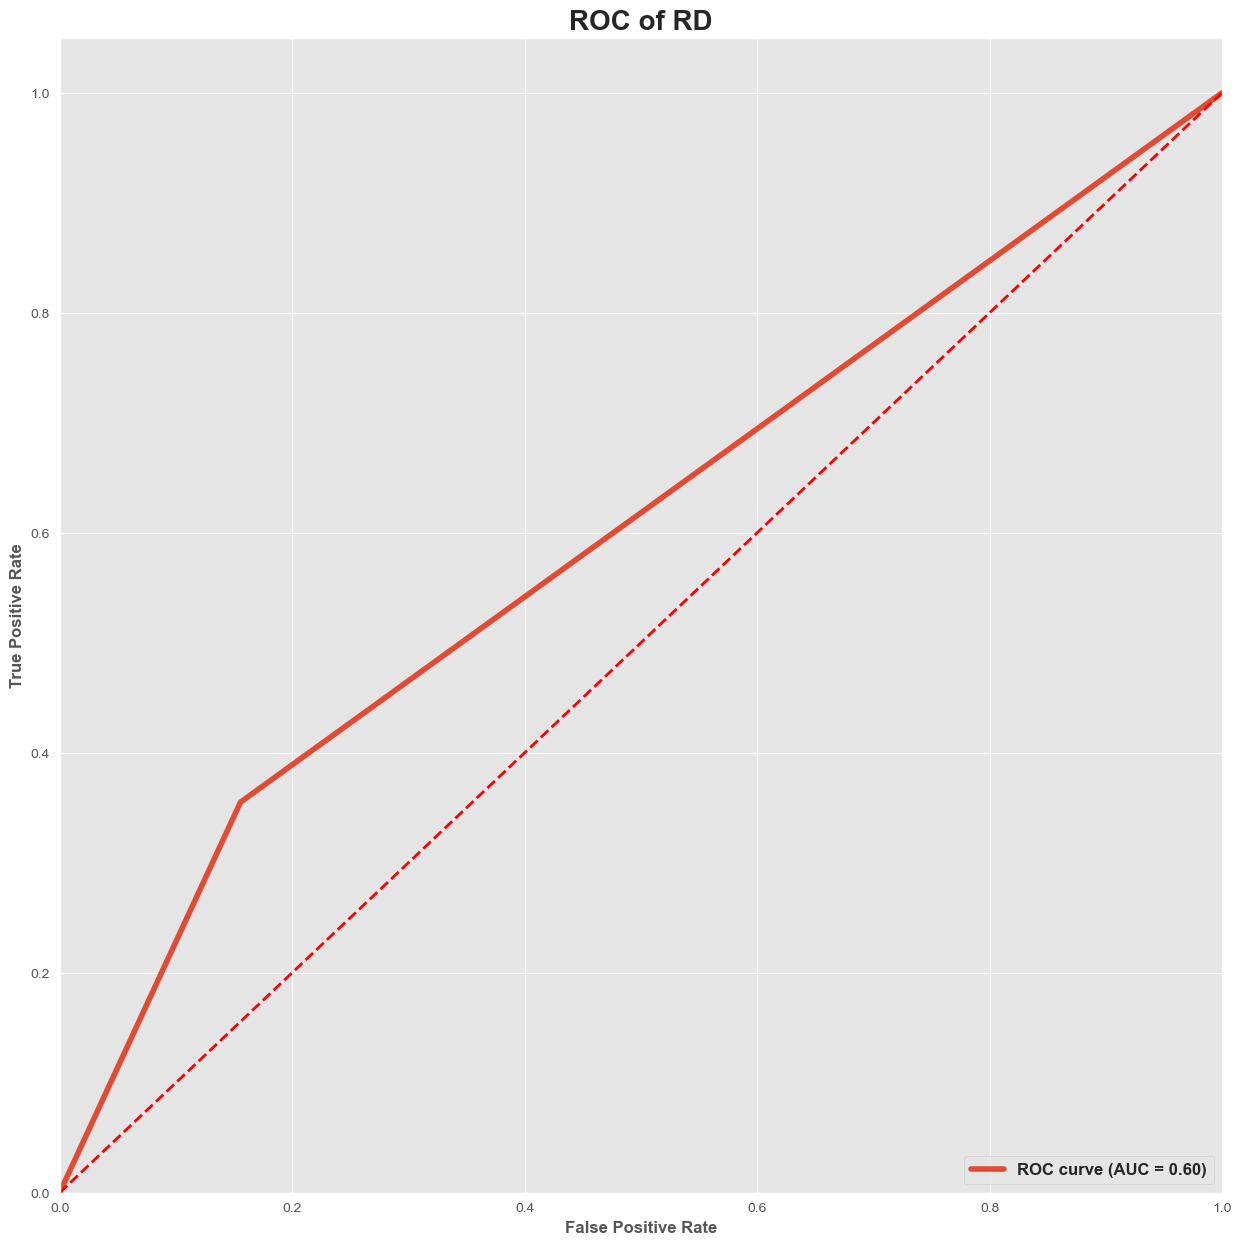

In [35]:

fpr, tpr, _ = roc_curve(y_test, binary_pred)
fig, ax = plt.subplots(1, 1, figsize=(15, 15))


# Tính diện tích dưới đường cong ROC (AUC)
roc_auc = auc(fpr, tpr)

# Vẽ đường cong ROC
ax.plot(fpr, tpr, lw=4, label='ROC curve (AUC = %0.2f)' % roc_auc)
ax.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=12, weight='bold')  # Đặt kích thước và độ dày cho nhãn trục x
ax.set_ylabel('True Positive Rate', fontsize=12, weight='bold')   # Đặt kích thước và độ dày cho nhãn trục y
ax.set_title(f'ROC of {name}',fontsize=20, weight='bold')  # Đặt kích thước và độ dày cho tiêu đề
ax.legend(loc="lower right", prop={'size': 12, 'weight': 'bold'})  # Đặt kích thước và độ dày cho chú thích

#### Blending ensemble

In [36]:
# from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import accuracy_score

# Assume we have X_train, y_train, X_val, y_val from our dataset

# Split the training set further into training and validation sets for blending
# X_train_base, X_blend, y_train_base, y_blend = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


# Make predictions on the blending set
pred1 = lgbm_model.predict(x_train[feature_selection['LGBM']])
pred2 = xgb_model.predict(x_train[feature_selection['XGB']])
# pred3 = best_xgb_model.predict(x_test)

# Combine predictions as input features for the meta-learner
blend_features = np.column_stack((pred1, pred2))

# Train the meta-learner on the blending set
# meta_learner = LogisticRegression()
clone_rf=rf_model
clone_rf.fit(blend_features, y_train)

# Make predictions on the validation set
blend_pred = clone_rf.predict(np.column_stack((xgb_model.predict(x_test[feature_selection['XGB']]), lgbm_model.predict(x_test[feature_selection['LGBM']]))))

# Evaluate the blended model
blend_accuracy = accuracy_score(y_test, blend_pred)
print("Blending Accuracy:", blend_accuracy)


Blending Accuracy: 0.9270976616231087


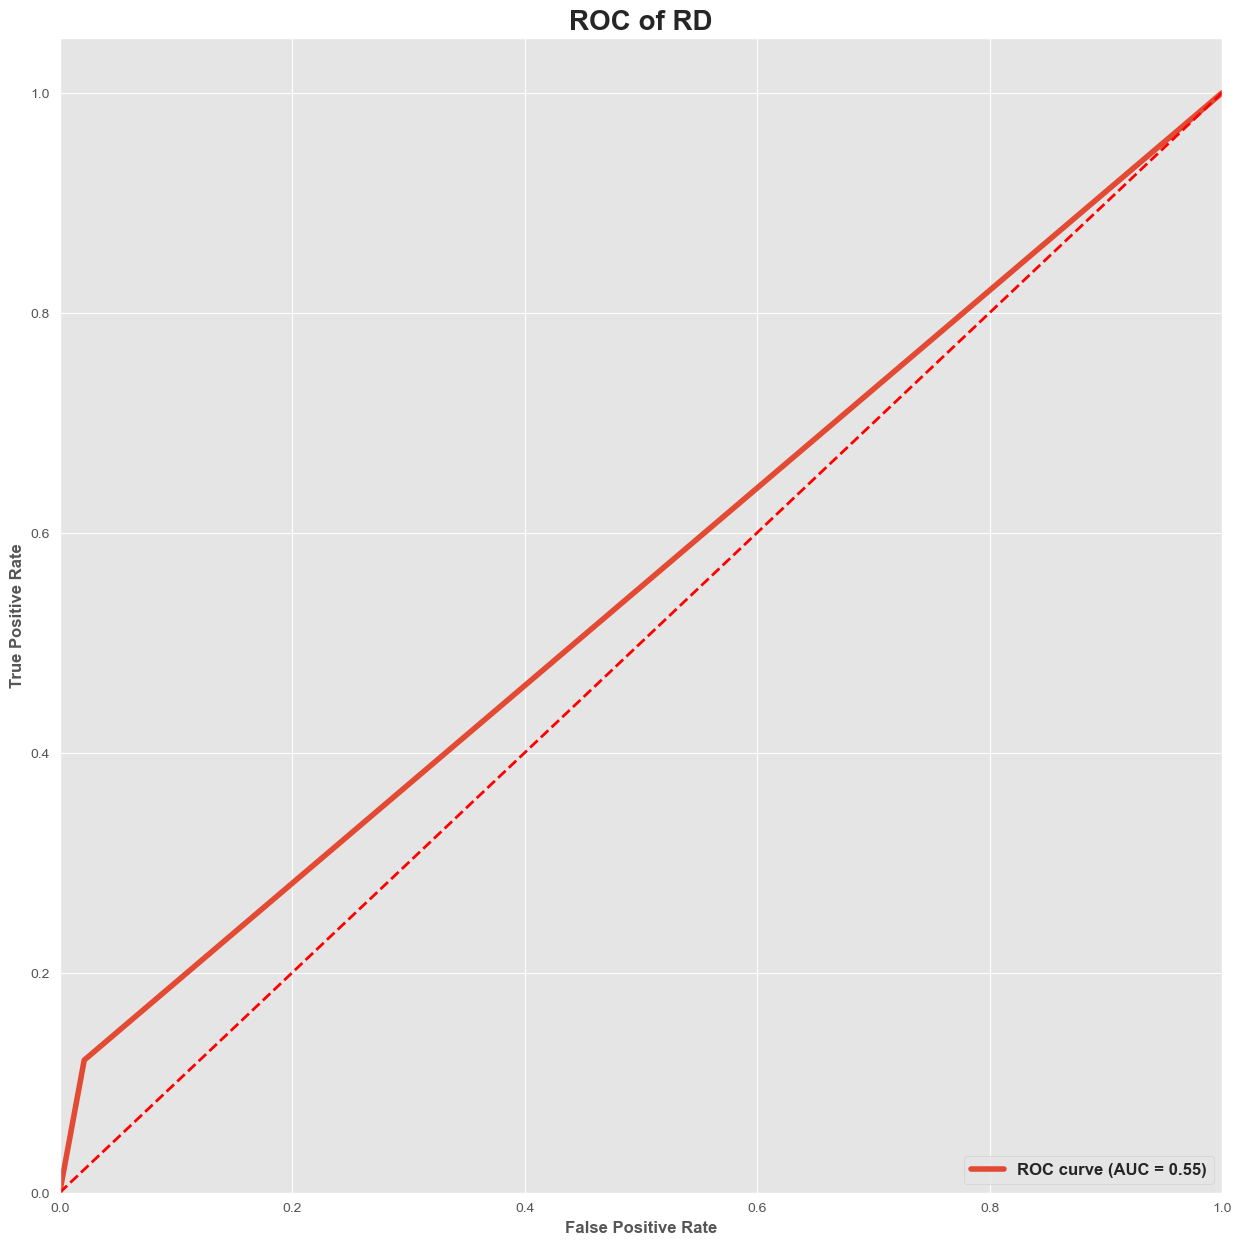

In [37]:

fpr, tpr, _ = roc_curve(y_test, blend_pred)
fig, ax = plt.subplots(1, 1, figsize=(15, 15))


# Tính diện tích dưới đường cong ROC (AUC)
roc_auc = auc(fpr, tpr)

# Vẽ đường cong ROC
ax.plot(fpr, tpr, lw=4, label='ROC curve (AUC = %0.2f)' % roc_auc)
ax.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=12, weight='bold')  # Đặt kích thước và độ dày cho nhãn trục x
ax.set_ylabel('True Positive Rate', fontsize=12, weight='bold')   # Đặt kích thước và độ dày cho nhãn trục y
ax.set_title(f'ROC of {name}',fontsize=20, weight='bold')  # Đặt kích thước và độ dày cho tiêu đề
ax.legend(loc="lower right", prop={'size': 12, 'weight': 'bold'})  # Đặt kích thước và độ dày cho chú thích

#### Stacking ensemble

In [51]:
from mlxtend.classifier import StackingClassifier
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score
# from sklearn.linear_model import LogisticRegression
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.svm import SVC
# from sklearn.ensemble import RandomForestClassifier

# Load your dataset và chia thành tập huấn luyện và tập kiểm tra
# X_train, X_test, y_train, y_test = ...
xgb_model=joblib.load(f'{save_dir}/xgb_model.joblib')
rf_model=joblib.load(f'{save_dir}/rf_model.joblib')
lgbm_model=joblib.load(f'{save_dir}/lgbm_model.joblib')

# Khởi tạo các mô hình cơ sở
base_models = [
    xgb_model,
    rf_model,
    lgbm_model,
    xgb_model_tuning
]

# Khởi tạo mô hình meta-learner
meta_learner = xgb_model

# rf_pred = rf_model.predict(x_train[feature_selection['RD']])
# svm_pred =lgbm_model.predict(x_train[feature_selection['LGBM']])
# bg_pred = xgb_model.predict(x_train[feature_selection['XGB']])


# # keras_pred = keras_clf.predict(x_test)
# stacked_input = np.column_stack((rf_pred,bg_pred,svm_pred))

# Tạo mô hình Stacking
# stacking_model = StackingClassifier(estimators=base_models, final_estimator=meta_learner)

stacked_model = StackingClassifier(
    classifiers=base_models,
    meta_classifier=meta_learner
)

# Huấn luyện mô hình Stacking
stacked_model.fit(x_train, y_train)

# Dự đoán trên tập kiểm tra
y_pred = stacked_model.predict(x_test)

# Đánh giá độ chính xác của mô hình
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


[LightGBM] [Info] Number of positive: 10399, number of negative: 9715
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000784 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1193
[LightGBM] [Info] Number of data points in the train set: 20114, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.517003 -> initscore=0.068039
[LightGBM] [Info] Start training from score 0.068039
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

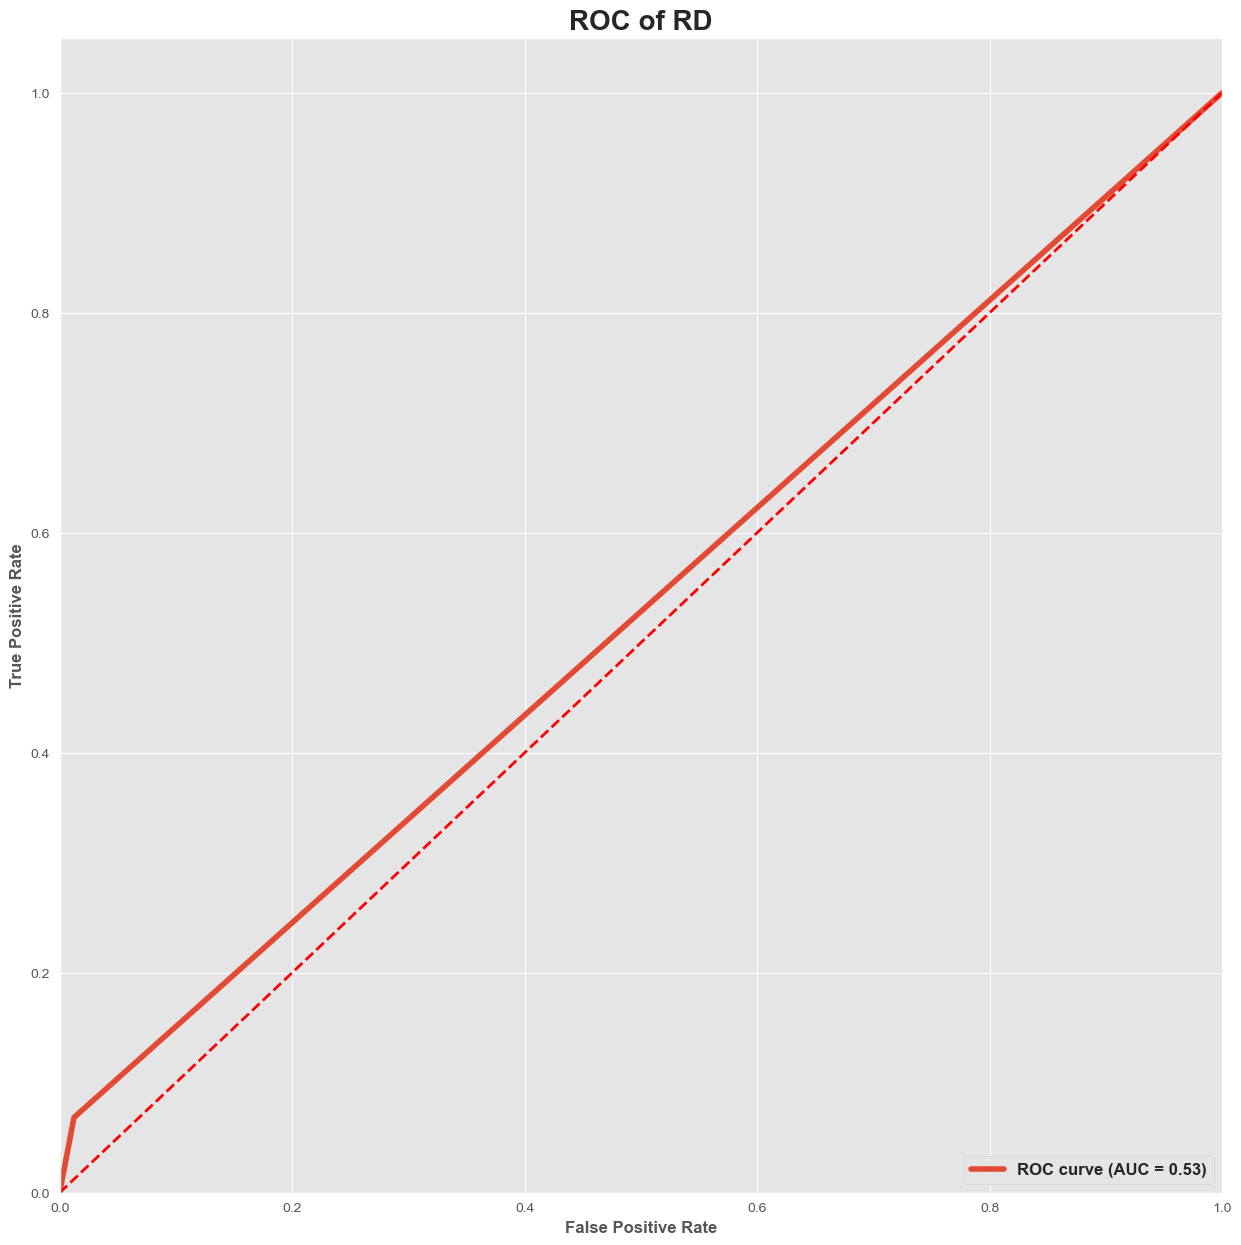

In [52]:

fpr, tpr, _ = roc_curve(y_test, y_pred)
fig, ax = plt.subplots(1, 1, figsize=(15, 15))


# Tính diện tích dưới đường cong ROC (AUC)
roc_auc = auc(fpr, tpr)

# Vẽ đường cong ROC
ax.plot(fpr, tpr, lw=4, label='ROC curve (AUC = %0.2f)' % roc_auc)
ax.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=12, weight='bold')  # Đặt kích thước và độ dày cho nhãn trục x
ax.set_ylabel('True Positive Rate', fontsize=12, weight='bold')   # Đặt kích thước và độ dày cho nhãn trục y
ax.set_title(f'ROC of {name}',fontsize=20, weight='bold')  # Đặt kích thước và độ dày cho tiêu đề
ax.legend(loc="lower right", prop={'size': 12, 'weight': 'bold'})  # Đặt kích thước và độ dày cho chú thích